<center> <h1>Final Project Computer Vision - Accident Detection</h1></center>
<hr>
<br>
<center> <h4>Ichwan Rizky Wahyudin</h4></center>

In [34]:
import numpy as np
import pandas as pd
import os

In [35]:
!pip install -U torchvision

In [36]:
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A

import matplotlib.pyplot as plt
%matplotlib inline

In [37]:
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm
from torchvision.utils import draw_bounding_boxes

In [38]:
print(torch.__version__)
print(torchvision.__version__)

2.3.0+cu121
0.18.0+cu121


In [39]:
!pip install pycocotools
from pycocotools.coco import COCO

In [40]:
from albumentations.pytorch import ToTensorV2

Augmentasi menggunakan albumnetations data kami karena kemampuannya untuk bounding-box

In [41]:
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(512, 512),
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(512, 512),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

## Dataset

In [42]:
class AccidentDetection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        super().__init__(root, transforms, transform, target_transform)
        self.split = split
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json"))
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]
    
    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))
    
    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))
        
        boxes = [t['bbox'] + [t['category_id']] for t in target]
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)
        
        image = transformed['image']
        boxes = transformed['bboxes']
        
        new_boxes = []
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])
        
        boxes = torch.tensor(new_boxes, dtype=torch.float32)
        
        targ = {}
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # we have a different area
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ # scale images
    def __len__(self):
        return len(self.ids)

In [43]:
dataset_path = "/kaggle/input/accident-detection-coco/"

In [44]:
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=0.37s)
creating index...
index created!


{0: {'id': 0, 'name': 'car-accident', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'accident', 'supercategory': 'car-accident'},
 2: {'id': 2, 'name': 'non-accident', 'supercategory': 'car-accident'}}

This code just gets a list of classes

In [45]:
classes = [i[1]['name'] for i in categories.items()]
classes

['car-accident', 'accident', 'non-accident']

In [46]:
train_dataset = AccidentDetection(root=dataset_path, transforms=get_transforms(True))

loading annotations into memory...
Done (t=0.16s)
creating index...
index created!


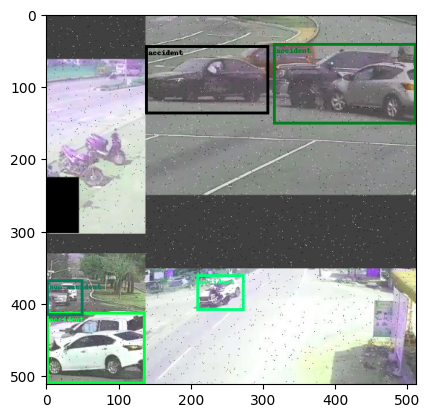

In [47]:
sample = train_dataset[2]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
).permute(1, 2, 0))

In [48]:
len(train_dataset)

8127

## Model
Model yang digunakan adalah FasterRCNN dengan tulang punggung `MobileNetV3-Large`. 

In [49]:
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

This is our collating function for the train dataloader, it allows us to create batches of data that can be easily pass into the model

In [50]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [51]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)

The following blocks ensures that the model can take in the data and that it will not crash during training

In [52]:
images,targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
output = model(images, targets)

In [53]:
device = torch.device("cuda")

In [54]:
model = model.to(device)

## Optimizer

In [55]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)

In [56]:
import sys

## Training

In [ ]:
def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()
    all_losses = []
    all_losses_dict = []
    
    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()
        
        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)
        
        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping trainig")
            print(loss_dict)
            sys.exit(1)
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
    all_losses_dict = pd.DataFrame(all_losses_dict)
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))

In [58]:
num_epochs=10

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)

100%|██████████| 2032/2032 [04:09<00:00,  8.15it/s]


Epoch 0, lr: 0.010000, loss: 0.614394, loss_classifier: 0.275413, loss_box: 0.287023, loss_rpn_box: 0.011218, loss_object: 0.040740


100%|██████████| 2032/2032 [03:59<00:00,  8.48it/s]


Epoch 1, lr: 0.010000, loss: 0.563388, loss_classifier: 0.246926, loss_box: 0.280506, loss_rpn_box: 0.009281, loss_object: 0.026675


100%|██████████| 2032/2032 [03:55<00:00,  8.63it/s]


Epoch 2, lr: 0.010000, loss: 0.553228, loss_classifier: 0.238422, loss_box: 0.283731, loss_rpn_box: 0.008507, loss_object: 0.022568


100%|██████████| 2032/2032 [03:52<00:00,  8.75it/s]


Epoch 3, lr: 0.010000, loss: 0.538926, loss_classifier: 0.227290, loss_box: 0.283653, loss_rpn_box: 0.008060, loss_object: 0.019922


100%|██████████| 2032/2032 [03:49<00:00,  8.86it/s]


Epoch 4, lr: 0.010000, loss: 0.529463, loss_classifier: 0.220547, loss_box: 0.282865, loss_rpn_box: 0.007784, loss_object: 0.018266


100%|██████████| 2032/2032 [03:47<00:00,  8.95it/s]


Epoch 5, lr: 0.010000, loss: 0.530887, loss_classifier: 0.218124, loss_box: 0.288521, loss_rpn_box: 0.007503, loss_object: 0.016738


100%|██████████| 2032/2032 [03:45<00:00,  9.01it/s]


Epoch 6, lr: 0.010000, loss: 0.525288, loss_classifier: 0.212317, loss_box: 0.290275, loss_rpn_box: 0.007256, loss_object: 0.015439


100%|██████████| 2032/2032 [03:43<00:00,  9.08it/s]


Epoch 7, lr: 0.010000, loss: 0.521406, loss_classifier: 0.210056, loss_box: 0.289386, loss_rpn_box: 0.007029, loss_object: 0.014935


100%|██████████| 2032/2032 [03:42<00:00,  9.14it/s]


Epoch 8, lr: 0.010000, loss: 0.521464, loss_classifier: 0.207124, loss_box: 0.293443, loss_rpn_box: 0.006954, loss_object: 0.013943


100%|██████████| 2032/2032 [03:40<00:00,  9.22it/s]


Epoch 9, lr: 0.010000, loss: 0.521282, loss_classifier: 0.205635, loss_box: 0.295453, loss_rpn_box: 0.006820, loss_object: 0.013373


## Predict

In [59]:
model.eval()
torch.cuda.empty_cache()

In [66]:
valid_dataset = AccidentDetection(root=dataset_path, split="valid", transforms=get_transforms(False))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [62]:
img, _ = valid_dataset[5]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]

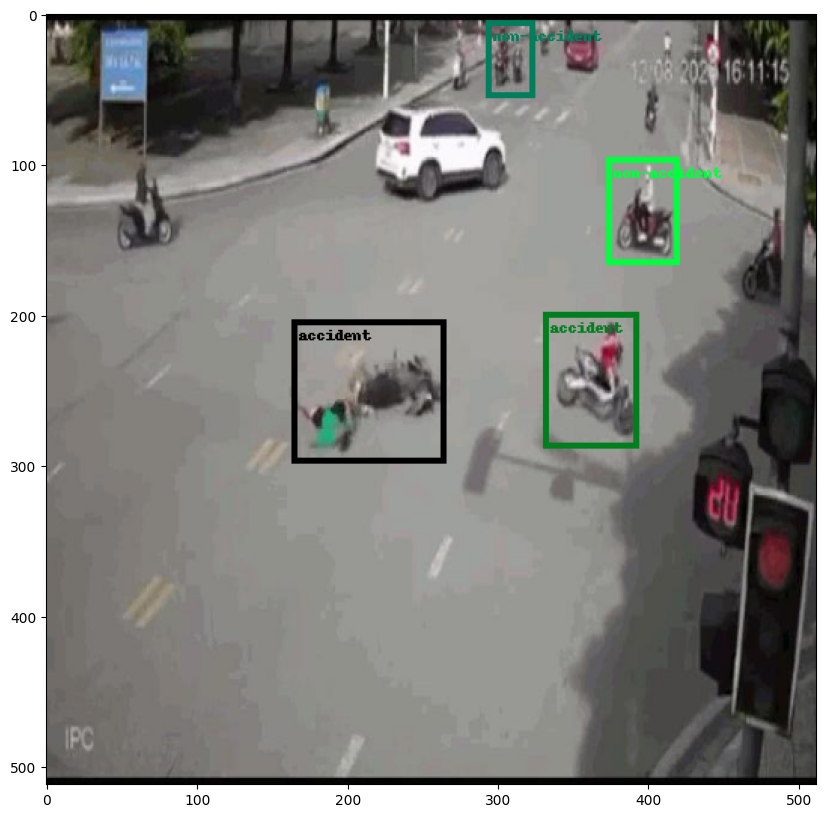

In [63]:
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.8],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
).permute(1, 2, 0))